# Separability of legal documents according to precedent citations

- Lucas Emanuel Resck Domingues
- Machine Learning assignment
- Professor Rodrigo Targino, FGV-EMAp

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Binding-Precedents" data-toc-modified-id="Binding-Precedents-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Binding Precedents</a></span></li><li><span><a href="#Dataset-description" data-toc-modified-id="Dataset-description-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dataset description</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li></ul></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Methodology</a></span><ul class="toc-item"><li><span><a href="#Dataset-split" data-toc-modified-id="Dataset-split-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dataset split</a></span></li><li><span><a href="#Text-preprocessing" data-toc-modified-id="Text-preprocessing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Text preprocessing</a></span></li><li><span><a href="#Document-embeddings" data-toc-modified-id="Document-embeddings-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Document embeddings</a></span></li><li><span><a href="#Machine-learning-models" data-toc-modified-id="Machine-learning-models-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Machine learning models</a></span></li><li><span><a href="#Performance-metrics" data-toc-modified-id="Performance-metrics-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Performance metrics</a></span></li></ul></li><li><span><a href="#Results-and-discussion" data-toc-modified-id="Results-and-discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and discussion</a></span><ul class="toc-item"><li><span><a href="#Dataset-split-and-text-preprocessing" data-toc-modified-id="Dataset-split-and-text-preprocessing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dataset split and text preprocessing</a></span></li><li><span><a href="#Document-embedding" data-toc-modified-id="Document-embedding-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Document embedding</a></span></li><li><span><a href="#Machine-learning-models" data-toc-modified-id="Machine-learning-models-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Machine learning models</a></span><ul class="toc-item"><li><span><a href="#Linear-regression" data-toc-modified-id="Linear-regression-5.3.1"><span class="toc-item-num">5.3.1&nbsp;&nbsp;</span>Linear regression</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-5.3.2"><span class="toc-item-num">5.3.2&nbsp;&nbsp;</span>Logistic regression</a></span></li><li><span><a href="#Linear-Discriminant-Analysis" data-toc-modified-id="Linear-Discriminant-Analysis-5.3.3"><span class="toc-item-num">5.3.3&nbsp;&nbsp;</span>Linear Discriminant Analysis</a></span></li><li><span><a href="#K-nearest-neighbours" data-toc-modified-id="K-nearest-neighbours-5.3.4"><span class="toc-item-num">5.3.4&nbsp;&nbsp;</span>K-nearest neighbours</a></span></li><li><span><a href="#Random-forest" data-toc-modified-id="Random-forest-5.3.5"><span class="toc-item-num">5.3.5&nbsp;&nbsp;</span>Random forest</a></span></li><li><span><a href="#Support-Vector-Machine" data-toc-modified-id="Support-Vector-Machine-5.3.6"><span class="toc-item-num">5.3.6&nbsp;&nbsp;</span>Support Vector Machine</a></span></li></ul></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Setup

In [1]:
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import spacy

In [2]:
data_path = os.path.join('../data/docs')
random_state = 42

## Introduction

The Brazilian Supreme Court (STF) is the highest law court in Brazil. It produces a huge number of documents during its functioning, \textit{e.g.}, there were produced more than 1 million STF decisions between 2011 and 2020 \cite{}. STF is not the only institution that deals with overload: it is spread all over the Brazilian Judicial System.

One approach to solve this problem is the so-called precedent: when a similar case has to be decided again, this new decision can be taken based on the referenced old decision. This way, cases are solved faster. Many precedents about a subject in a court are consolidated in what is called a ``súmula'', a document that resumes the court understanding about that subject. However, the application of this understanding is not mandatory, and the judge can take a different decision. This situation can lead not only to judicial inefficiency, but also to judicial insecurity: similar cases with different results.

With this situation in mind, STF was allowed, in 2004, by Constitutional Amendment, to create "Súmulas Vinculantes", which we will call here "Binding Precedents", or just BPs. They are basically the old súmulas, but with mandatory application. These BPs are frequently cited in the STF decisions.

It seems trivial that documents that cite the same precedents have the same subjects, and documents that cite different precedents have different subjects, in general. However, can machine learning models and algorithms identify this pattern themselves? That is, if a trained machine learning model is presented to a document, can it predict which precedent is being cited? These questions are very relevant because, if the answer is yes, artificial intelligence algorithms can be very helpful in assisting legal experts during their analysis, considering the big number of long legal documents.

This situation of predicting the correct precedent is what is being called here as ``separability'' of documents. In this assignment, this separability will consider Binding Precedents in STF decisions. This work is organized as follows.

## Dataset

### Binding Precedents

Until June 2021, 58 Binding Precendents have already been created. For example, take a look at BP 10's text:

\textit{``Viola a cláusula de reserva de plenário (CF, artigo 97) a decisão de órgão fracionário de tribunal que, embora não declare expressamente a inconstitucionalidade de lei ou ato normativo do Poder Público, afasta sua incidência, no todo ou em parte.''}

Although it can lead to some insights, we are not interested in studying the meaning of all the BPs.

### Dataset description

The dataset used thoughout this work is composed by decisions generated by STF that cite at least one Binding Precedent. Although these documents are public, they are very difficult to be accessed, mainly when it is necessary a big amount of data. This way, we use a dataset gathered in the context of Supremo em Números project \cite{}, from FGV's Law School.

The dataset, in the way we have it, is composed by 58 CSV files of structured data, with columns:
- title: document title, formed by date, document type and an ID;
- raw_text: document's raw text;
- i_cite: list of cited precedents, including BPs, already extracted from the raw texts;
- date: document's publication date.

See a sample:

In [3]:
sample = pd.read_csv(os.path.join(data_path, 'docs_sv_10.csv')).sample(random_state=random_state)
sample

,title,raw_text,i_cite,date
10286,20181116_ARE_1175289_15339061159,Documento assinado digitalmente conforme MP n°...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 're 3...",2018-11-16


In [4]:
print(sample.to_latex())

\begin{tabular}{lllll}
\toprule
{} &                             title &                                           raw\_text &                                             i\_cite &        date \\
\midrule
10286 &  20181116\_ARE\_1175289\_15339061159 &  Documento assinado digitalmente conforme MP n°... &  ['sum. vinc. 10 N/A STF N/A 11937 1187', 're 3... &  2018-11-16 \\
\bottomrule
\end{tabular}



This is how an usual document looks like:

In [5]:
print(sample.raw_text.iloc[0][:1000])

Documento assinado digitalmente conforme MP n° 2.200-2/2001 de 24/08/2001. O documento pode ser acessado pelo endereço
http://www.stf.jus.br/portal/autenticacao/autenticarDocumento.asp sob o código EFF0-327E-F95C-C7FE e senha E40E-F1C1-C945-6B0D

RECURSO EXTRAORDINÁRIO COM AGRAVO 1.175.289 RIO DE JANEIRO

RELATOR : MIN. LUIZ FUX
RECTE.(S) :DJALMA ESTELLA CABRAL JUNIOR 
ADV.(A/S) :ANA CAROLINA VIEIRA DA ROSA 
RECDO.(A/S) :MINISTÉRIO PÚBLICO DO ESTADO DO RIO DE 

PROC.(A/S)(ES) :PROCURADOR-GERAL DE JUSTIÇA DO ESTADO DO 

JANEIRO 

RIO DE JANEIRO 

RECURSO EXTRAORDINÁRIO COM 
AGRAVO. PENAL E PROCESSUAL 
PENAL. CRIME DE TRÁFICO ILÍCITO 
DE ENTORPECENTES. ARTIGO 33 DA 
LEI 11.343/2006. ALEGAÇÃO DE OFENSA 
AO ARTIGO 5º, XLVI, DA 
CONSTITUIÇÃO FEDERAL. PRINCÍPIO 
DA INDIVIDUALIZAÇÃO DA PENA. 
DOSIMETRIA DA PENA. MATÉRIA DE 
ÍNDOLE INFRACONSTITUCIONAL. 
ALEGAÇÃO DE OFENSA AO ARTIGO 5º, 
LVII, DA CONSTITUIÇÃO FEDERAL. 
PRINCÍPIO DA PRESUNÇÃO DE 
INOCÊNCIA. NEGATIVA DE AUTORIA 
DELITIVA. NECESSI

### Exploratory Data Analysis

Although the dataset is very simple (few, autoexplainable columns), we can analyse it more deeply to better understand it. Let's start, for example, checking how many citations each BP has.

In [6]:
dfs = []
for bp in range(1, 58+1):
    try:
        df = pd.read_csv(os.path.join(data_path, 'docs_sv_{}.csv'.format(bp)))
        dfs.append(df)
    except pd.errors.EmptyDataError as e:
        dfs.append(None)

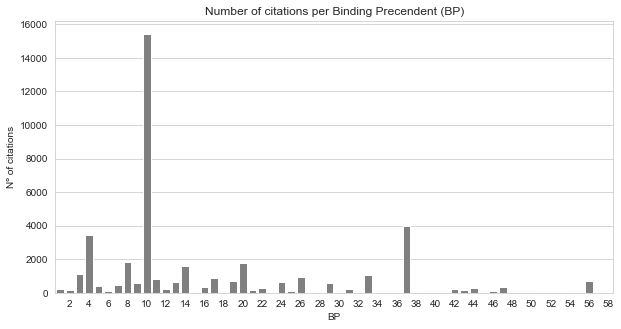

In [7]:
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(10, 5))

sns.barplot(x=list(range(1, 58+1)), y=[len(df) if df is not None else 0 for df in dfs], color='gray', ax=ax)

ax.set_xticklabels([str(i) if i % 2 == 0 else '' for i in range(1, 59)])
plt.title('Number of citations per Binding Precendent (BP)')
plt.xlabel('BP')
plt.ylabel('Nº of citations');

We see that the number of citations per BP is not uniform. BP 10, for example, has the greates number of citations, followed by 37, 4 and 8. This huge difference in number of citations can impact our analysis if we don't work around it.

We already know the documents are long, but one could want to know how long these documents are. If we split each document at whitespaces and newlines and count the number of ``words'', we have an estimative of word count distribution of the documents.

In [8]:
df = pd.concat(dfs, ignore_index=True)
df = df[~df.title.duplicated()].reset_index(drop=True)
df

,title,raw_text,i_cite,date
0,19700101_RE_422410_3279878,DESPACHO: Dê-se vista à PGR para elaboração de...,['sum. vinc. 1 N/A STF N/A'],1970-01-01
1,20081111_RE_581675_2329113,DECISÃO\n\nVistos.\n\nCaixa Econômica Federal ...,['sum. vinc. 1 N/A STF N/A'],2008-11-11
2,19700101_RE_606035_3280058,DESPACHO: Dê-se vista à PGR para elaboração de...,['sum. vinc. 1 N/A STF N/A'],1970-01-01
3,19700101_RE_637135_1424289,DJe 05/09/2011\n\nDecisão sobre Repercussão Ge...,['sum. vinc. 1 N/A STF N/A'],1970-01-01
4,20171122_Rcl_28954_313332094,MEDIDA CAUTELAR NA RECLAMAÇÃO 28.954 DISTRITO ...,['sum. vinc. 1 N/A STF N/A 167 15'],2017-11-22
...,...,...,...,...
38359,20161205_HC_138632_310876555,MEDIDA CAUTELAR NO HABEAS CORPUS 138.632 MINAS...,"['hc 118212 4419627 STF N/A 1728 348', 'hc 668...",2016-12-05
38360,20181031_HC_162238_15338953871,Ementa e AcórdãoDocumento assinado digitalment...,"['hc 108877 3748163 STJ N/A 337 184', 'hc 1360...",2018-10-31
38361,20181015_HC_152642_15338840024,Ementa e AcórdãoDocumento assinado digitalment...,"['sum. 440 N/A STJ N/A 290 72', 'hc 402602 470...",2018-10-15
38362,20180927_HC_162543_15338719562,Documento assinado digitalmente conforme MP n°...,"['aresp 1169 4004318 STJ N/A 4 3', 'hc 108877 ...",2018-09-27


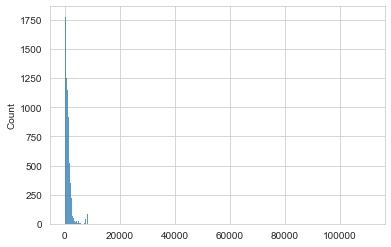

In [9]:
counts = np.array(df.raw_text.apply(lambda x: len(x.split())).to_list())
sns.histplot(data=counts);

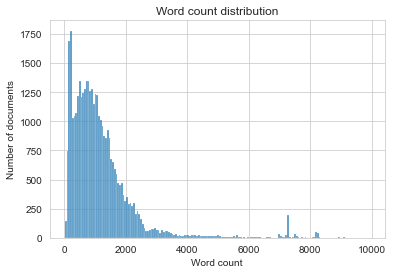

In [10]:
sns.histplot(data=counts[counts < 10000])
plt.title('Word count distribution')
plt.xlabel('Word count')
plt.ylabel('Number of documents');

There are some special documents (more than 10k words), but their analysis is not our focus. In general, documents are shorter than 6k words, with mode around 1k.

Although document titles are the same, many of them share the same raw text.

In [11]:
df.raw_text.duplicated().sum()/len(df)

0.11474298821812115

This ``duplicate'' rate is around 11\%, and can also impact our subsequent analysis. This way, we need to work around these duplicated documents before fitting out models.

Finally, one could want to see the distribution of publication date.

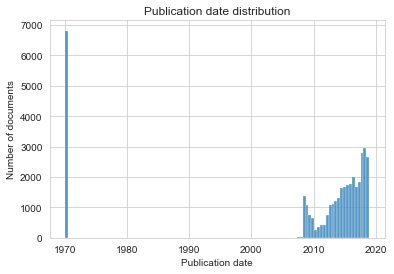

In [12]:
dates = np.array(pd.to_datetime(df.date).to_list())
sns.histplot(data=dates)
plt.title('Publication date distribution')
plt.xlabel('Publication date')
plt.ylabel('Number of documents');

In [13]:
np.min(dates[dates > pd.to_datetime('1970')]), np.max(dates[dates > pd.to_datetime('1970')])

(Timestamp('2003-11-28 00:00:00'), Timestamp('2018-12-19 00:00:00'))

Date distribution has support between 2003 and 2018, but it really concentrates itself between 2008 and 2018. It is clear that many documents have publication year 1970, however this information is acting like a missing value. Although this is problematic, that is, many documents do not have publication date, it will not impact our models, because we will work only with raw texts.

## Methodology

### Dataset split

The main goal of this work is to assert whether traditional machine learning models can ``separate'' documents according to BP citations. We will create two datasets, training and test datasets, that will be used to fit and to test the models, respectively. Some of the models will be fitted in training dataset in a cross validation style, i.e., training data will be splitted in K sets, and, for each set, the model is fitted in all other sets and validated in this set; in the end all metrics are aggregated. This is very usefull in the task of choosing hyperparameters of some models.

- Each document cites one BP
- Remove duplicates
- 4 most cited BPs
- Balanced dataset
- Supervised
    - training set
    - test set
    - cross validation

### Text preprocessing

- lowercase
- tokenize
- lemmatization
- stopwords
- punctuation

### Document embeddings

- TF-IDF
<!-- - Doc2vec -->
<!-- - Universal Sentence Encoder -->
- Dimensionality reduction
    - Truncated SVD
- scaler
<!-- - more vectors? -->

### Machine learning models

- Linear regression
    - Ridge
<!--     - LASSO -->
- Logistic regression
- Linear Discriminant Analysis
<!-- - QDA -->
- KNN
<!-- - Árvores -->
<!-- - Bagging -->
- Random forest
<!-- - Boosting -->
- Support Vector Machines
- Principal Component Analysis
- K-means
- Hierarchical clustering
<!-- - Gaussian Mixture -->
- Latent Dirichlet Analysis

### Performance metrics

- Accuracy
- Confusion matrix
<!-- - RoC curve -->
<!-- - Cross validation -->
- recall
- precision

## Results and discussion

### Dataset split and text preprocessing

In [14]:
def one_citation(i_cite):
    '''Assert whether the document cites only one BP.'''
    pattern = 'sum. vinc. [0-9]{1,2}'
    citations = re.findall(pattern, i_cite)
    if len(set(citations)) == 1:
        return True
    return False

In [15]:
sizes = dict()
for bp in range(1, 58+1):
    df = dfs[bp-1]
    if df is not None:
        df = df[df.i_cite.apply(lambda x: one_citation(x))]
        df = df[~df.raw_text.duplicated()]
        df['label'] = bp
        dfs[bp-1] = df
        sizes[bp] = len(df)
    else:
        sizes[bp] = 0

In [16]:
sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:5]

[(10, 13094), (37, 2917), (4, 2540), (20, 1582), (14, 1401)]

In [17]:
df_10 = dfs[10-1].sample(1401, random_state=42)
df_37 = dfs[37-1].sample(1401, random_state=42)
df_4 = dfs[4-1].sample(1401, random_state=42)
df_20 = dfs[20-1].sample(1401, random_state=42)
df_14 = dfs[14-1].sample(1401, random_state=42)

In [18]:
df = pd.concat([df_10, df_37, df_4, df_20, df_14], ignore_index=True)
df

,title,raw_text,i_cite,date,label
0,20091014_Rcl_8918_2675717,DECISÃO: 1. Trata-se de reclamação ajuizada pe...,"['sum. vinc. 10 N/A STF N/A', 'rcl 2716 222994...",2009-10-14,10
1,20131119_Rcl_16548_184585137,MEDIDA CAUTELAR NA RECLAMAÇÃO 16.548 RIO GRAND...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 'sum....",2013-11-19,10
2,20110927_ARE_652911_1607711,DJe 06/12/2011\n\nEmenta e Acórdão\n\n27/09/20...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 're 5...",2011-09-27,10
3,20170621_ARE_1052676_312039223,RECURSO EXTRAORDINÁRIO COM AGRAVO 1.052.676 DI...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 'are ...",2017-06-21,10
4,19700101_Rcl_8890_3256407,"DECISÃO: Trata-se de reclamação, ajuizada pelo...","['sum. vinc. 10 N/A STF N/A', 're 240096 17380...",1970-01-01,10
...,...,...,...,...,...
7000,20161028_RE_771482_310624548,RECURSO EXTRAORDINÁRIO 771.482 DISTRITO FEDERA...,"['re 593727 2641697 STF QO 252 27', 're 872628...",2016-10-28,14
7001,19700101_Rcl_9363_3456757,DESPACHO\n\nRECLAMAÇÃO. PROCESSO PENAL. INQUÉR...,"['aco 808 2322945 STF N/A', 'ms 27405 2625481 ...",1970-01-01,14
7002,20120327_HC_85202_3109294,"DECISÃO: No presente habeas corpus, a defesa r...","['hc 84548 2229923 STF N/A', 'hc 84965 2250572...",2012-03-27,14
7003,20130808_Rcl_16019_161421263,MEDIDA CAUTELAR NA RECLAMAÇÃO 16.019 MARANHÃO\...,"['sum. vinc. 14 N/A STF N/A 978 150', 'hc 2112...",2013-08-08,14


In [19]:
X = df.raw_text.to_list()
y = np.array(df.label.to_list())

In [20]:
nlp = spacy.load('pt_core_news_sm', disable=['tagger', 'parser', 'ner'])

def preprocessing(text):
    '''Basic text preprocessing.'''
    # Tokenize, lowercase, lemmatize, and remove stopwords and punctuation
    text = nlp(text)
    text = [token.lemma_.lower() for token in text if not token.is_stop and not token.is_punct]
    text = [token for token in text if token not in ['\n', '\n\n', '\n\n\n', '>', '<', 'c', 'e', 'o']]
    return ' '.join(text)

In [21]:
X = [preprocessing(x) for x in tqdm(X)]

  0%|          | 0/7005 [00:00<?, ?it/s]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

In [23]:
stk = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Document embedding

In [24]:
tf_idf = TfidfVectorizer(
    lowercase=False,
    smooth_idf=True
)

X_train = tf_idf.fit_transform(X_train)
X_test = tf_idf.transform(X_test)
X_train.shape, X_test.shape

((5604, 44550), (1401, 44550))

In [25]:
t_svd = TruncatedSVD(
    n_components=50,
    random_state=42
)
X_train = t_svd.fit_transform(X_train)
X_test = t_svd.transform(X_test)
X_train.shape, X_test.shape

((5604, 50), (1401, 50))

In [26]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Machine learning models

#### Linear regression

In [27]:
sns.set_style('white')

In [28]:
def evaluate(clf, X_test, y_test):
    '''Evaluate our model.'''
    print(classification_report(y_test, clf.predict(X_test)))
    plot_confusion_matrix(
        clf,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize='true'
    )

              precision    recall  f1-score   support

           4       0.96      0.91      0.94       280
          10       0.94      0.93      0.93       280
          14       0.94      0.99      0.96       280
          20       0.99      0.95      0.97       281
          37       0.90      0.95      0.93       280

    accuracy                           0.95      1401
   macro avg       0.95      0.95      0.95      1401
weighted avg       0.95      0.95      0.95      1401



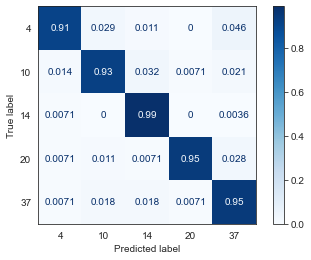

In [29]:
ridge = RidgeClassifierCV(
    cv=stk
)

ridge.fit(X_train_scaled, y_train)

evaluate(ridge, X_test_scaled, y_test)

#### Logistic regression

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.5s finished


              precision    recall  f1-score   support

           4       0.98      0.97      0.97       280
          10       0.96      0.96      0.96       280
          14       0.98      0.99      0.99       280
          20       0.97      0.97      0.97       281
          37       0.95      0.96      0.95       280

    accuracy                           0.97      1401
   macro avg       0.97      0.97      0.97      1401
weighted avg       0.97      0.97      0.97      1401



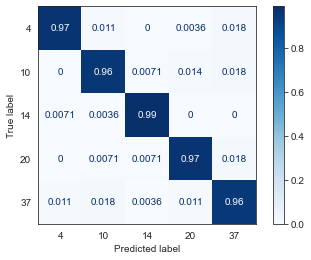

In [30]:
lr = LogisticRegressionCV(
    Cs=10,
    cv=stk,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    max_iter=1000
)

lr.fit(X_train_scaled, y_train)

evaluate(lr, X_test_scaled, y_test)

#### Linear Discriminant Analysis

              precision    recall  f1-score   support

           4       0.97      0.91      0.94       280
          10       0.91      0.95      0.93       280
          14       0.97      0.99      0.98       280
          20       0.99      0.93      0.96       281
          37       0.90      0.96      0.93       280

    accuracy                           0.95      1401
   macro avg       0.95      0.95      0.95      1401
weighted avg       0.95      0.95      0.95      1401



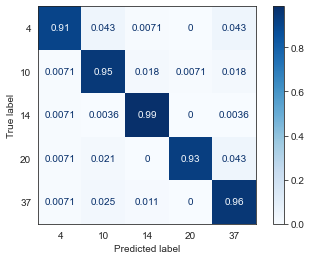

In [31]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
evaluate(lda, X_test_scaled, y_test)

#### K-nearest neighbours

In [32]:
%%time

knn = GridSearchCV(
    KNeighborsClassifier(n_jobs=-1),
    param_grid={
        'n_neighbors': list(range(1, 200+1, 5))
    },
    n_jobs=-1,
    cv=stk,
    verbose=3
)

knn.fit(X_train_scaled, y_train)
knn.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
CPU times: user 607 ms, sys: 21.6 ms, total: 628 ms
Wall time: 19.6 s


{'n_neighbors': 1}

              precision    recall  f1-score   support

           4       0.93      0.95      0.94       280
          10       0.87      0.90      0.89       280
          14       0.95      0.96      0.96       280
          20       0.97      0.95      0.96       281
          37       0.92      0.90      0.91       280

    accuracy                           0.93      1401
   macro avg       0.93      0.93      0.93      1401
weighted avg       0.93      0.93      0.93      1401



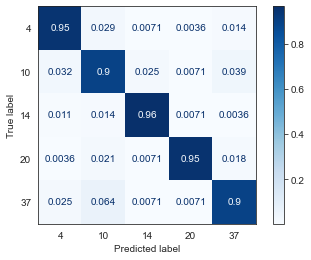

In [33]:
evaluate(knn, X_test_scaled, y_test)

#### Random forest

In [34]:
%%time

rf = GridSearchCV(
    RandomForestClassifier(
        max_depth=None,
        n_jobs=-1,
        random_state=random_state,
        verbose=1
    ),
    param_grid={
        'n_estimators': [10, 100],
        'max_depth': [None, 10, 100],
    },
    n_jobs=-1,
    cv=stk,
    verbose=3
)

rf.fit(X_train_scaled, y_train)
rf.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s


CPU times: user 7.45 s, sys: 62 ms, total: 7.51 s
Wall time: 14.4 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


{'max_depth': None, 'n_estimators': 100}

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           4       0.98      0.96      0.97       280
          10       0.91      0.95      0.93       280
          14       0.98      0.99      0.99       280
          20       0.98      0.96      0.97       281
          37       0.94      0.93      0.93       280

    accuracy                           0.96      1401
   macro avg       0.96      0.96      0.96      1401
weighted avg       0.96      0.96      0.96      1401



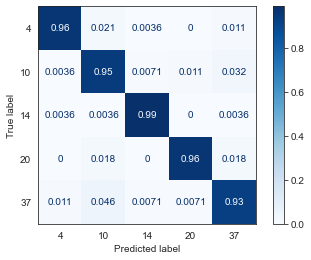

In [35]:
evaluate(rf, X_test_scaled, y_test)

#### Support Vector Machine

In [36]:
%%time

svm = GridSearchCV(
    SVC(
        verbose=True,
        random_state=random_state
    ),
    param_grid=[
        {
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
        },
        {
            'kernel': ['linear'],
            'C': [1, 10, 100, 1000]
        }
    ],
    n_jobs=-1,
    cv=stk,
    verbose=3
)

svm.fit(X_train_scaled, y_train)
svm.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LibSVM]CPU times: user 835 ms, sys: 5.17 ms, total: 841 ms
Wall time: 1min 45s


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           4       0.99      0.97      0.98       280
          10       0.95      0.97      0.96       280
          14       0.98      0.99      0.98       280
          20       0.98      0.97      0.98       281
          37       0.96      0.96      0.96       280

    accuracy                           0.97      1401
   macro avg       0.97      0.97      0.97      1401
weighted avg       0.97      0.97      0.97      1401



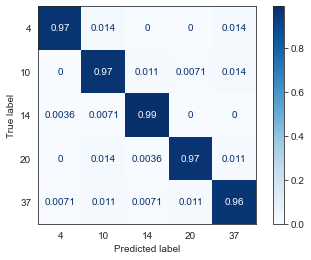

In [37]:
evaluate(svm, X_test_scaled, y_test)

## References